In [2]:
#import libraries

# from google.colab import drive
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import scipy
from scipy.signal import butter, filtfilt, iirnotch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim


from tqdm import tqdm
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, balanced_accuracy_score, roc_auc_score,  roc_curve
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount("/content/drive")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

Mounted at /content/drive


In [4]:
#prepare functions for filtering

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut=1, highcut=40, fs=500, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)

def notch_filter(data, freq=50, fs=500, quality_factor=30):
    b, a = iirnotch(freq / (fs / 2), quality_factor)
    return filtfilt(b, a, data)

In [5]:
#import the data and filter the signals
# This could be change depending if you download or not the data

ECG_folder = "/content/drive/MyDrive/WP_02_data/1_batch_extracted"
ECG_folder_2batch = "/content/drive/MyDrive/WP_02_data/2_batch_extracted"


tabular_data = pd.read_excel("/content/drive/MyDrive/WP_02_data/VALETUDO_database_1st_batch_en_all_info.xlsx")
tabular_data_2batch = pd.read_excel(r"/content/drive/MyDrive/WP_02_data/VALETUDO_database_2nd_batch_en_all_info.xlsx")

# --- Load and filter both batches ---
ECGs_1 = [f for f in os.listdir(ECG_folder) if f.endswith(".mat")]
ECGs_2 = [f for f in os.listdir(ECG_folder_2batch) if f.endswith(".mat")]

def extract_patient_id(filename):
    return int(filename.split(".")[0])

ECGs_1.sort(key=extract_patient_id)
ECGs_2.sort(key=extract_patient_id)

signals_1 = np.empty((len(ECGs_1), 5000, 12))
signals_2 = np.empty((len(ECGs_2), 5000, 12))

for index, ecg_path in enumerate(ECGs_1):
    filepath = os.path.join(ECG_folder, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    for i in range(12):
        ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])
        ecg[:, i] = notch_filter(ecg[:, i])
    signals_1[index, :, :] = ecg

for index, ecg_path in enumerate(ECGs_2):
    filepath = os.path.join(ECG_folder_2batch, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    for i in range(12):
        ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])
        ecg[:, i] = notch_filter(ecg[:, i])
    signals_2[index, :, :] = ecg

# --- Concatenate signals and tabular data ---
signals = np.concatenate([signals_1, signals_2], axis=0)
tabular_data = pd.concat([
    tabular_data.sort_values(by="ECG_patient_id").reset_index(drop=True),
    tabular_data_2batch.sort_values(by="ECG_patient_id").reset_index(drop=True)
], ignore_index=True)

print("Combined signals shape:", signals.shape)
print("Combined tabular shape:", tabular_data.shape)



Combined signals shape: (526, 5000, 12)
Combined tabular shape: (526, 18)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
print(f"nb pos: {np.sum(tabular_data['sport_ability']==1)}")
print(f"% pos: {np.sum(tabular_data['sport_ability']==1)/len(tabular_data['sport_ability'])*100:.2f}%")

nb pos: 360
% pos: 68.44%


In [ ]:
#function to extract segment

def segment_ecg(signal, tabular_data, segment_length=2500):

    segments = np.zeros((signal.shape[0], segment_length, signal.shape[2]))
    index = 0
    for i in range(signal.shape[0]):

      start = 0 # we take the start at the middle or elsewhere
      end = start + segment_length
      segments[index, :, :] = signal[i, start:end, :]
      index += 1

    return segments, tabular_data

In [ ]:
# Dataset modificato: Solo Segnali
class ECGDataset(Dataset):
    def __init__(self, signals, labels):
        # PyTorch Conv1d si aspetta: (Batch Size, Channels, Length)
        # I dati originali erano (N, 5000, 12), li trasformiamo in (N, 12, 5000)
        # O (N, 12, 2500) se hai già tagliato il segmento
        if signals.shape[1] > signals.shape[2]:
             self.signals = torch.tensor(signals, dtype=torch.float32).permute(0, 2, 1)
        else:
             self.signals = torch.tensor(signals, dtype=torch.float32)

        self.labels = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Ritorna solo Segnale ed Etichetta
        return self.signals[idx], self.labels[idx]

In [ ]:
# Architettura Semplice CNN 1D (Senza rami tabulari o GRU)
class Simple1DCNN(nn.Module):
    def __init__(self, num_leads=12):
        super(Simple1DCNN, self).__init__()

        # Blocco 1: Da 12 canali a 32
        self.conv1 = nn.Conv1d(in_channels=num_leads, out_channels=32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        # Blocco 2: Da 32 a 64
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # Blocco 3: Da 64 a 128
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        # Global Average Pooling: Riduce la dimensione temporale a 1
        # Indipendentemente dalla lunghezza del segnale (2500 o 5000), uscirà un vettore di dim 128
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Fully Connected finale per la classificazione
        self.fc1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.5) # Aiuta a prevenire l'overfitting
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # Input x shape: [Batch, 12, Length]

        # Convolutional Blocks
        x = self.pool1(F.gelu(self.bn1(self.conv1(x))))
        x = self.pool2(F.gelu(self.bn2(self.conv2(x))))
        x = self.pool3(F.gelu(self.bn3(self.conv3(x))))

        # Global Pooling
        x = self.global_pool(x) # Shape: [Batch, 128, 1]
        x = x.squeeze(-1)       # Shape: [Batch, 128]

        # Classifier
        x = F.gelu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))

        return x

In [ ]:
#implementation of the ten fold cross-validation

strat_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

f1_list_all_folds = []
f1_list_all_folds_train = []
sensitivity_list_all_folds = []
sensitivity_list_all_folds_train = []
specificity_list_all_folds = []
specificity_list_all_folds_train = []
accuracy_list_all_folds = []
accuracy_list_all_folds_train = []
auc_score_list_all_folds = []
auc_score_list_all_folds_train = []
fpr_list_all_folds = []
tpr_list_all_folds = []
test_loss_all_folds = []
train_loss_all_folds = []
epochs_all_fold = []
train_loss_max = []
test_loss_max = []

num_epocs = 50

for train_index, test_index in strat_kf.split(tabular_data, tabular_data['sport_ability']):
    X_train, X_test = tabular_data.iloc[train_index,:], tabular_data.iloc[test_index,:]
    ecg_train = signals[train_index,:,:]
    ecg_test = signals[test_index,:,:]

    ecg_train_segments, tabular_train_expand = segment_ecg(ecg_train, X_train)
    ecg_test_segments, tabular_test_expand = segment_ecg(ecg_test, X_test)

    Y_train = tabular_train_expand['sport_ability']
    Y_test = tabular_test_expand['sport_ability']

    X_train_final = tabular_train_expand.drop(columns=['sport_ability', 'ECG_patient_id'])
    X_test_final = tabular_test_expand.drop(columns=['sport_ability', 'ECG_patient_id'])

    X_train_final['age_at_exam'] = X_train_final['age_at_exam'].apply(lambda x: x if 0.0 <= x <= 100.0 else np.nan)
    X_train_final['trainning_load'] = X_train_final['trainning_load'].apply(lambda x: x if 0 < x <= 4 else np.nan)

    imputer = IterativeImputer()
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_final), columns=X_train_final.columns)

    categorical_cols = ['sex', 'sport_classification']
    numeric_cols = ['age_at_exam', 'height', 'weight', 'trainning_load']

    X_test_final['age_at_exam'] = X_test_final['age_at_exam'].apply(lambda x: x if 0.0 <= x <= 100.0 else np.nan)
    X_test_final['trainning_load'] = X_test_final['trainning_load'].apply(lambda x: x if 0 < x <= 4 else np.nan)

    X_test_imputed = pd.DataFrame(imputer.transform(X_test_final), columns=X_test_final.columns)

    scaler = StandardScaler()
    X_train_imputed[numeric_cols] = scaler.fit_transform(X_train_imputed[numeric_cols])
    X_test_imputed[numeric_cols] = scaler.transform(X_test_imputed[numeric_cols])

    for col in categorical_cols:
        X_train_imputed[col] = X_train_imputed[col].apply(lambda x: -1 if x == 0 else x)
        X_test_imputed[col] = X_test_imputed[col].apply(lambda x: -1 if x == 0 else x)

    train_final_df = pd.concat([X_train_imputed[numeric_cols], X_train_imputed[categorical_cols]], axis=1)
    test_final_df = pd.concat([X_test_imputed[numeric_cols], X_test_imputed[categorical_cols]], axis=1)

    train_dataset = ECGDataset(ecg_train_segments, Y_train)
    test_dataset = ECGDataset(ecg_test_segments, Y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = Simple1DCNN(num_leads=12).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    ## Variabili early-stopping
    best_test_loss = float('inf')
    patience = 5
    trigger_times = 0

    f1_list_single_fold = []
    f1_list_single_fold_train = []
    sensitivity_list_single_fold = []
    sensitivity_list_single_fold_train = []
    specificity_list_single_fold = []
    specificity_list_single_fold_train = []
    accuracy_list_single_fold = []
    accuracy_list_single_fold_train = []
    auc_score_list_single_fold = []
    auc_score_list_single_fold_train = []
    fpr_list_single_fold = []
    tpr_list_single_fold = []
    train_loss_single_fold = []
    test_loss_single_fold = []
    epochs_single_fold = []

    for epoch in tqdm(range(num_epocs)):

        train_loss = 0
        correct = 0

        all_labels = []
        all_preds = []
        all_outputs = []

        for signals_ecg, labels in train_loader:
            model.train()
            # Rimosso tabular.to(device)
            signals_ecg, labels = signals_ecg.to(device), labels.to(device)

            optimizer.zero_grad()

            # Passiamo solo il segnale al modello
            outputs = model(signals_ecg)

            loss = criterion(outputs.squeeze(), labels.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            predicted = (outputs > 0.6).int()
            labels = labels.int()
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu())
            all_preds.extend(predicted.cpu())
            all_outputs.extend(outputs.cpu())

        print('\n')
        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}")

        train_loss_single_fold.append(train_loss/len(train_loader))
        train_accuracy = accuracy_score(all_labels, all_preds) * 100
        f1 = f1_score(all_labels, all_preds)
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        auc_score = roc_auc_score(all_labels, all_preds)

        f1_list_single_fold_train.append(f1)
        sensitivity_list_single_fold_train.append(sensitivity)
        specificity_list_single_fold_train.append(specificity)
        accuracy_list_single_fold_train.append(train_accuracy)
        auc_score_list_single_fold_train.append(auc_score)

        model.eval()

        all_labels = []
        all_preds = []
        all_outputs = []

        with torch.no_grad():

            correct = 0
            test_loss = 0

            for signals_ecg, labels in test_loader:
                # Rimosso tabular.to(device)
                signals_ecg, labels = signals_ecg.to(device), labels.to(device)

                # Passiamo solo il segnale
                outputs = model(signals_ecg)

                loss = criterion(outputs.squeeze(), labels.squeeze())
                test_loss += loss.item()
                predicted = (outputs.squeeze() > 0.6).int()
                labels = labels.squeeze().int()
                correct += (predicted.squeeze() == labels).sum().item()
                all_labels.extend(labels.cpu())
                all_preds.extend(predicted.cpu())
                all_outputs.extend(outputs.squeeze().cpu())

            test_loss /= len(test_loader)

            test_loss_single_fold.append(test_loss)
            test_accuracy = accuracy_score(all_labels, all_preds) * 100
            f1 = f1_score(all_labels, all_preds)
            tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)
            auc_score = roc_auc_score(all_labels, all_preds)

            f1_list_single_fold.append(f1)
            sensitivity_list_single_fold.append(sensitivity)
            specificity_list_single_fold.append(specificity)
            accuracy_list_single_fold.append(test_accuracy)
            auc_score_list_single_fold.append(auc_score)
            fpr, tpr, _ = roc_curve(all_labels, all_outputs)
            fpr_list_single_fold.append(fpr)
            tpr_list_single_fold.append(tpr)
            epochs_single_fold.append(epoch)

            print(f"Test loss: {test_loss}, Accuracy: {test_accuracy:.2f}%", f"F1 Score: {f1:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, AUC: {auc_score:.4f}")
            print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

            ## early stopping
            if test_loss < best_test_loss:
                 best_test_loss = test_loss
                 trigger_times = 0
                 # Salviamo i pesi del modello attuale perché è il migliore finora
                 torch.save(model.state_dict(), 'best_model_fold.pth')
            else:
                 trigger_times += 1
                 # print(f"Patience: {trigger_times}/{patience}") # Decommenta se vuoi vedere il contatore

                 if trigger_times >= patience:
                     print(f"Early stopping attivato all'epoca {epoch+1}!")
                     # IMPORTANTE: Prima di uscire, ricarichiamo i pesi migliori salvati
                     # Altrimenti il modello rimarrebbe quello "peggiorato" dell'ultima epoca
                     model.load_state_dict(torch.load('best_model_fold.pth'))
                     break # Esce dal ciclo "for epoch" e passa al prossimo Fold

    max_f1 = max(f1_list_single_fold)
    max_f1_index = f1_list_single_fold.index(max_f1)

    f1_list_all_folds.append(f1_list_single_fold[max_f1_index])
    f1_list_all_folds_train.append(f1_list_single_fold_train[max_f1_index])
    sensitivity_list_all_folds.append(sensitivity_list_single_fold[max_f1_index])
    sensitivity_list_all_folds_train.append(sensitivity_list_single_fold_train[max_f1_index])
    specificity_list_all_folds.append(specificity_list_single_fold[max_f1_index])
    specificity_list_all_folds_train.append(specificity_list_single_fold_train[max_f1_index])
    accuracy_list_all_folds.append(accuracy_list_single_fold[max_f1_index])
    accuracy_list_all_folds_train.append(accuracy_list_single_fold_train[max_f1_index])
    auc_score_list_all_folds.append(auc_score_list_single_fold[max_f1_index])
    auc_score_list_all_folds_train.append(auc_score_list_single_fold_train[max_f1_index])
    fpr_list_all_folds.append(fpr_list_single_fold[max_f1_index])
    tpr_list_all_folds.append(tpr_list_single_fold[max_f1_index])
    test_loss_all_folds.append(test_loss_single_fold)
    test_loss_max.append(test_loss_single_fold[max_f1_index])
    train_loss_all_folds.append(train_loss_single_fold)
    train_loss_max.append(train_loss_single_fold[max_f1_index])
    epochs_all_fold.append(epochs_single_fold[max_f1_index])



print(f"Accuracy: {accuracy_list_all_folds}")
print(f"Accuracy Train: {accuracy_list_all_folds_train}")
print(f"F1 Score: {f1_list_all_folds}")
print(f"F1 Score Train: {f1_list_all_folds_train}")
print(f"Sensitivity: {sensitivity_list_all_folds}")
print(f"Sensitivity Train: {sensitivity_list_all_folds_train}")
print(f"Specificity: {specificity_list_all_folds}")
print(f"Specificity Train: {specificity_list_all_folds_train}")
print(f"AUC: {auc_score_list_all_folds}")
print(f"AUC Train: {auc_score_list_all_folds_train}")
print(f"Test Loss: {test_loss_max}")
print(f"Train Loss: {train_loss_max}")
print(f"Epochs: {epochs_all_fold}")

  2%|▏         | 1/50 [00:03<02:41,  3.29s/it]



Epoch 1, Train Loss: 0.646626369158427
Test loss: 0.6233471632003784, Accuracy: 66.04% F1 Score: 0.7907, Sensitivity: 0.9444, Specificity: 0.0588, AUC: 0.5016
TP: 34, FP: 16, TN: 1, FN: 2


  4%|▍         | 2/50 [00:03<01:11,  1.49s/it]



Epoch 2, Train Loss: 0.6068366686503093
Test loss: 0.5903687477111816, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  6%|▌         | 3/50 [00:03<00:42,  1.10it/s]



Epoch 3, Train Loss: 0.5809445599714915
Test loss: 0.5795426070690155, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  8%|▊         | 4/50 [00:03<00:28,  1.59it/s]



Epoch 4, Train Loss: 0.5738299250602722
Test loss: 0.5658742338418961, Accuracy: 66.04% F1 Score: 0.7568, Sensitivity: 0.7778, Specificity: 0.4118, AUC: 0.5948
TP: 28, FP: 10, TN: 7, FN: 8


 10%|█         | 5/50 [00:04<00:21,  2.10it/s]



Epoch 5, Train Loss: 0.547522775332133
Test loss: 0.5459075719118118, Accuracy: 69.81% F1 Score: 0.8140, Sensitivity: 0.9722, Specificity: 0.1176, AUC: 0.5449
TP: 35, FP: 15, TN: 2, FN: 1


 12%|█▏        | 6/50 [00:04<00:16,  2.62it/s]



Epoch 6, Train Loss: 0.5334692736466725
Test loss: 0.5687207281589508, Accuracy: 62.26% F1 Score: 0.7561, Sensitivity: 0.8611, Specificity: 0.1176, AUC: 0.4894
TP: 31, FP: 15, TN: 2, FN: 5


Epoch 7, Train Loss: 0.5059346119562785


 16%|█▌        | 8/50 [00:04<00:11,  3.52it/s]

Test loss: 0.5804223418235779, Accuracy: 62.26% F1 Score: 0.7619, Sensitivity: 0.8889, Specificity: 0.0588, AUC: 0.4739
TP: 32, FP: 16, TN: 1, FN: 4


Epoch 8, Train Loss: 0.4902384678522746
Test loss: 0.6279657334089279, Accuracy: 62.26% F1 Score: 0.6774, Sensitivity: 0.5833, Specificity: 0.7059, AUC: 0.6446
TP: 21, FP: 5, TN: 12, FN: 15


 18%|█▊        | 9/50 [00:04<00:10,  3.88it/s]



Epoch 9, Train Loss: 0.5012335042158763
Test loss: 0.6911302953958511, Accuracy: 66.04% F1 Score: 0.7907, Sensitivity: 0.9444, Specificity: 0.0588, AUC: 0.5016
TP: 34, FP: 16, TN: 1, FN: 2


Epoch 10, Train Loss: 0.49858532746632894


 18%|█▊        | 9/50 [00:05<00:23,  1.75it/s]

Test loss: 0.6015758216381073, Accuracy: 60.38% F1 Score: 0.7407, Sensitivity: 0.8333, Specificity: 0.1176, AUC: 0.4755
TP: 30, FP: 15, TN: 2, FN: 6
Early stopping attivato all'epoca 10!



  2%|▏         | 1/50 [00:00<00:10,  4.86it/s]



Epoch 1, Train Loss: 0.6653913974761962
Test loss: 0.659492015838623, Accuracy: 32.08% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 17, FN: 36


  4%|▍         | 2/50 [00:00<00:10,  4.61it/s]



Epoch 2, Train Loss: 0.6036476850509643
Test loss: 0.5911364257335663, Accuracy: 69.81% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0588, AUC: 0.5294
TP: 36, FP: 16, TN: 1, FN: 0


  6%|▌         | 3/50 [00:00<00:09,  4.72it/s]



Epoch 3, Train Loss: 0.5826623956362407
Test loss: 0.5815139561891556, Accuracy: 75.47% F1 Score: 0.8312, Sensitivity: 0.8889, Specificity: 0.4706, AUC: 0.6797
TP: 32, FP: 9, TN: 8, FN: 4


  8%|▊         | 4/50 [00:00<00:09,  4.62it/s]



Epoch 4, Train Loss: 0.5577115118503571
Test loss: 0.5302801728248596, Accuracy: 81.13% F1 Score: 0.8684, Sensitivity: 0.9167, Specificity: 0.5882, AUC: 0.7525
TP: 33, FP: 7, TN: 10, FN: 3


 10%|█         | 5/50 [00:01<00:09,  4.76it/s]



Epoch 5, Train Loss: 0.5417535603046417
Test loss: 0.5334442108869553, Accuracy: 77.36% F1 Score: 0.8421, Sensitivity: 0.8889, Specificity: 0.5294, AUC: 0.7092
TP: 32, FP: 8, TN: 9, FN: 4


Epoch 6, Train Loss: 0.5349039634068807


 12%|█▏        | 6/50 [00:01<00:09,  4.75it/s]

Test loss: 0.5248050391674042, Accuracy: 77.36% F1 Score: 0.8286, Sensitivity: 0.8056, Specificity: 0.7059, AUC: 0.7557
TP: 29, FP: 5, TN: 12, FN: 7


Epoch 7, Train Loss: 0.5251614173253377


 16%|█▌        | 8/50 [00:01<00:08,  4.88it/s]

Test loss: 0.5334409177303314, Accuracy: 75.47% F1 Score: 0.8219, Sensitivity: 0.8333, Specificity: 0.5882, AUC: 0.7108
TP: 30, FP: 7, TN: 10, FN: 6


Epoch 8, Train Loss: 0.5238446871439616
Test loss: 0.5700452327728271, Accuracy: 58.49% F1 Score: 0.6207, Sensitivity: 0.5000, Specificity: 0.7647, AUC: 0.6324
TP: 18, FP: 4, TN: 13, FN: 18


 18%|█▊        | 9/50 [00:01<00:09,  4.50it/s]



Epoch 9, Train Loss: 0.5062659700711568
Test loss: 0.6478617340326309, Accuracy: 73.58% F1 Score: 0.8293, Sensitivity: 0.9444, Specificity: 0.2941, AUC: 0.6193
TP: 34, FP: 12, TN: 5, FN: 2


 20%|██        | 10/50 [00:02<00:09,  4.33it/s]



Epoch 10, Train Loss: 0.49885786374409996
Test loss: 0.5556724369525909, Accuracy: 54.72% F1 Score: 0.5556, Sensitivity: 0.4167, Specificity: 0.8235, AUC: 0.6201
TP: 15, FP: 3, TN: 14, FN: 21


 20%|██        | 10/50 [00:02<00:09,  4.09it/s]



Epoch 11, Train Loss: 0.4904512127240499
Test loss: 0.5367027670145035, Accuracy: 79.25% F1 Score: 0.8451, Sensitivity: 0.8333, Specificity: 0.7059, AUC: 0.7696
TP: 30, FP: 5, TN: 12, FN: 6
Early stopping attivato all'epoca 11!



  2%|▏         | 1/50 [00:00<00:13,  3.73it/s]



Epoch 1, Train Loss: 0.6482814947764078
Test loss: 0.6422591507434845, Accuracy: 32.08% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 17, FN: 36


  4%|▍         | 2/50 [00:00<00:13,  3.68it/s]



Epoch 2, Train Loss: 0.6105956594149272
Test loss: 0.6028281450271606, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:12,  3.71it/s]



Epoch 3, Train Loss: 0.5906586011250814
Test loss: 0.5830531716346741, Accuracy: 71.70% F1 Score: 0.8276, Sensitivity: 1.0000, Specificity: 0.1176, AUC: 0.5588
TP: 36, FP: 15, TN: 2, FN: 0


  8%|▊         | 4/50 [00:01<00:16,  2.83it/s]



Epoch 4, Train Loss: 0.5540028373400371
Test loss: 0.5630358755588531, Accuracy: 66.04% F1 Score: 0.7750, Sensitivity: 0.8611, Specificity: 0.2353, AUC: 0.5482
TP: 31, FP: 13, TN: 4, FN: 5


 10%|█         | 5/50 [00:01<00:14,  3.10it/s]



Epoch 5, Train Loss: 0.5447037160396576
Test loss: 0.5772936940193176, Accuracy: 66.04% F1 Score: 0.7692, Sensitivity: 0.8333, Specificity: 0.2941, AUC: 0.5637
TP: 30, FP: 12, TN: 5, FN: 6


 12%|█▏        | 6/50 [00:01<00:13,  3.25it/s]



Epoch 6, Train Loss: 0.5397753675778707
Test loss: 0.5628673881292343, Accuracy: 62.26% F1 Score: 0.7222, Sensitivity: 0.7222, Specificity: 0.4118, AUC: 0.5670
TP: 26, FP: 10, TN: 7, FN: 10


 14%|█▍        | 7/50 [00:02<00:11,  3.66it/s]



Epoch 7, Train Loss: 0.5278006752332052
Test loss: 0.5884441286325455, Accuracy: 62.26% F1 Score: 0.6774, Sensitivity: 0.5833, Specificity: 0.7059, AUC: 0.6446
TP: 21, FP: 5, TN: 12, FN: 15


Epoch 8, Train Loss: 0.5159276068210602


 16%|█▌        | 8/50 [00:02<00:10,  3.96it/s]

Test loss: 0.5610093325376511, Accuracy: 64.15% F1 Score: 0.7246, Sensitivity: 0.6944, Specificity: 0.5294, AUC: 0.6119
TP: 25, FP: 8, TN: 9, FN: 11


Epoch 9, Train Loss: 0.5036991337935129


 18%|█▊        | 9/50 [00:02<00:09,  4.25it/s]

Test loss: 0.5889330506324768, Accuracy: 71.70% F1 Score: 0.8052, Sensitivity: 0.8611, Specificity: 0.4118, AUC: 0.6364
TP: 31, FP: 10, TN: 7, FN: 5


Epoch 10, Train Loss: 0.5017372727394104


 22%|██▏       | 11/50 [00:02<00:08,  4.60it/s]

Test loss: 0.5921016335487366, Accuracy: 73.58% F1 Score: 0.8056, Sensitivity: 0.8056, Specificity: 0.5882, AUC: 0.6969
TP: 29, FP: 7, TN: 10, FN: 7


Epoch 11, Train Loss: 0.48584743539492287
Test loss: 0.5958745181560516, Accuracy: 75.47% F1 Score: 0.8395, Sensitivity: 0.9444, Specificity: 0.3529, AUC: 0.6487
TP: 34, FP: 11, TN: 6, FN: 2


 24%|██▍       | 12/50 [00:03<00:08,  4.74it/s]



Epoch 12, Train Loss: 0.4820485750834147
Test loss: 0.5891456604003906, Accuracy: 60.38% F1 Score: 0.6769, Sensitivity: 0.6111, Specificity: 0.5882, AUC: 0.5997
TP: 22, FP: 7, TN: 10, FN: 14


Epoch 13, Train Loss: 0.4681608557701111


 24%|██▍       | 12/50 [00:03<00:10,  3.68it/s]

Test loss: 0.6768909394741058, Accuracy: 62.26% F1 Score: 0.7368, Sensitivity: 0.7778, Specificity: 0.2941, AUC: 0.5359
TP: 28, FP: 12, TN: 5, FN: 8
Early stopping attivato all'epoca 13!



  2%|▏         | 1/50 [00:00<00:09,  4.90it/s]



Epoch 1, Train Loss: 0.6486387213071187
Test loss: 0.6499645411968231, Accuracy: 32.08% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 17, FN: 36


  4%|▍         | 2/50 [00:00<00:09,  4.85it/s]



Epoch 2, Train Loss: 0.601030174891154
Test loss: 0.6126278638839722, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:09,  4.81it/s]



Epoch 3, Train Loss: 0.5835202813148499
Test loss: 0.5977778136730194, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  8%|▊         | 4/50 [00:00<00:09,  4.90it/s]



Epoch 4, Train Loss: 0.5686437567075093
Test loss: 0.6120589077472687, Accuracy: 73.58% F1 Score: 0.8250, Sensitivity: 0.9167, Specificity: 0.3529, AUC: 0.6348
TP: 33, FP: 11, TN: 6, FN: 3


Epoch 5, Train Loss: 0.5511519193649292


 10%|█         | 5/50 [00:01<00:09,  4.77it/s]

Test loss: 0.576250433921814, Accuracy: 73.58% F1 Score: 0.8250, Sensitivity: 0.9167, Specificity: 0.3529, AUC: 0.6348
TP: 33, FP: 11, TN: 6, FN: 3


Epoch 6, Train Loss: 0.5451707184314728


 12%|█▏        | 6/50 [00:01<00:09,  4.75it/s]

Test loss: 0.5686715096235275, Accuracy: 71.70% F1 Score: 0.8101, Sensitivity: 0.8889, Specificity: 0.3529, AUC: 0.6209
TP: 32, FP: 11, TN: 6, FN: 4


Epoch 7, Train Loss: 0.5218558490276337


 14%|█▍        | 7/50 [00:01<00:08,  4.82it/s]

Test loss: 0.5972420424222946, Accuracy: 64.15% F1 Score: 0.7246, Sensitivity: 0.6944, Specificity: 0.5294, AUC: 0.6119
TP: 25, FP: 8, TN: 9, FN: 11


Epoch 8, Train Loss: 0.5164965689182281


 18%|█▊        | 9/50 [00:01<00:08,  4.91it/s]

Test loss: 0.5930780321359634, Accuracy: 66.04% F1 Score: 0.7353, Sensitivity: 0.6944, Specificity: 0.5882, AUC: 0.6413
TP: 25, FP: 7, TN: 10, FN: 11


Epoch 9, Train Loss: 0.5110044757525126
Test loss: 0.6215168833732605, Accuracy: 69.81% F1 Score: 0.8049, Sensitivity: 0.9167, Specificity: 0.2353, AUC: 0.5760
TP: 33, FP: 13, TN: 4, FN: 3


 20%|██        | 10/50 [00:02<00:08,  4.85it/s]



Epoch 10, Train Loss: 0.5118784765402477
Test loss: 0.6008340269327164, Accuracy: 69.81% F1 Score: 0.8049, Sensitivity: 0.9167, Specificity: 0.2353, AUC: 0.5760
TP: 33, FP: 13, TN: 4, FN: 3


 20%|██        | 10/50 [00:02<00:09,  4.40it/s]



Epoch 11, Train Loss: 0.535439380009969
Test loss: 0.5809832364320755, Accuracy: 69.81% F1 Score: 0.7949, Sensitivity: 0.8611, Specificity: 0.3529, AUC: 0.6070
TP: 31, FP: 11, TN: 6, FN: 5
Early stopping attivato all'epoca 11!



  2%|▏         | 1/50 [00:00<00:10,  4.62it/s]



Epoch 1, Train Loss: 0.6493483662605286
Test loss: 0.6440660357475281, Accuracy: 32.08% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 17, FN: 36


  4%|▍         | 2/50 [00:00<00:10,  4.65it/s]



Epoch 2, Train Loss: 0.6130518674850464
Test loss: 0.5871008932590485, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:10,  4.68it/s]



Epoch 3, Train Loss: 0.5873921950658162
Test loss: 0.5573732703924179, Accuracy: 67.92% F1 Score: 0.8046, Sensitivity: 0.9722, Specificity: 0.0588, AUC: 0.5155
TP: 35, FP: 16, TN: 1, FN: 1


  8%|▊         | 4/50 [00:00<00:09,  4.74it/s]



Epoch 4, Train Loss: 0.5667863806088765
Test loss: 0.5246410965919495, Accuracy: 71.70% F1 Score: 0.8052, Sensitivity: 0.8611, Specificity: 0.4118, AUC: 0.6364
TP: 31, FP: 10, TN: 7, FN: 5


 10%|█         | 5/50 [00:01<00:09,  4.75it/s]



Epoch 5, Train Loss: 0.562324031194051
Test loss: 0.5214185565710068, Accuracy: 71.70% F1 Score: 0.8101, Sensitivity: 0.8889, Specificity: 0.3529, AUC: 0.6209
TP: 32, FP: 11, TN: 6, FN: 4


 12%|█▏        | 6/50 [00:01<00:09,  4.79it/s]



Epoch 6, Train Loss: 0.5655633807182312
Test loss: 0.5022399425506592, Accuracy: 73.58% F1 Score: 0.8250, Sensitivity: 0.9167, Specificity: 0.3529, AUC: 0.6348
TP: 33, FP: 11, TN: 6, FN: 3


 14%|█▍        | 7/50 [00:01<00:09,  4.77it/s]



Epoch 7, Train Loss: 0.5339994490146637
Test loss: 0.5195065587759018, Accuracy: 71.70% F1 Score: 0.7826, Sensitivity: 0.7500, Specificity: 0.6471, AUC: 0.6985
TP: 27, FP: 6, TN: 11, FN: 9


 16%|█▌        | 8/50 [00:01<00:08,  4.72it/s]



Epoch 8, Train Loss: 0.518068673213323
Test loss: 0.49898506700992584, Accuracy: 73.58% F1 Score: 0.8158, Sensitivity: 0.8611, Specificity: 0.4706, AUC: 0.6658
TP: 31, FP: 9, TN: 8, FN: 5


 18%|█▊        | 9/50 [00:01<00:08,  4.79it/s]



Epoch 9, Train Loss: 0.5081645468870799
Test loss: 0.5297285169363022, Accuracy: 71.70% F1 Score: 0.8000, Sensitivity: 0.8333, Specificity: 0.4706, AUC: 0.6520
TP: 30, FP: 9, TN: 8, FN: 6


Epoch 10, Train Loss: 0.49076372583707173


 22%|██▏       | 11/50 [00:02<00:07,  4.90it/s]

Test loss: 0.5433436334133148, Accuracy: 71.70% F1 Score: 0.8101, Sensitivity: 0.8889, Specificity: 0.3529, AUC: 0.6209
TP: 32, FP: 11, TN: 6, FN: 4


Epoch 11, Train Loss: 0.4910139858722687
Test loss: 0.6128863394260406, Accuracy: 60.38% F1 Score: 0.6557, Sensitivity: 0.5556, Specificity: 0.7059, AUC: 0.6307
TP: 20, FP: 5, TN: 12, FN: 16


 24%|██▍       | 12/50 [00:02<00:07,  4.91it/s]



Epoch 12, Train Loss: 0.508371873696645
Test loss: 0.504114642739296, Accuracy: 67.92% F1 Score: 0.7792, Sensitivity: 0.8333, Specificity: 0.3529, AUC: 0.5931
TP: 30, FP: 11, TN: 6, FN: 6


 24%|██▍       | 12/50 [00:02<00:08,  4.43it/s]



Epoch 13, Train Loss: 0.46951253414154054
Test loss: 0.530774399638176, Accuracy: 64.15% F1 Score: 0.7077, Sensitivity: 0.6389, Specificity: 0.6471, AUC: 0.6430
TP: 23, FP: 6, TN: 11, FN: 13
Early stopping attivato all'epoca 13!



  2%|▏         | 1/50 [00:00<00:10,  4.62it/s]



Epoch 1, Train Loss: 0.64381422996521
Test loss: 0.6517289280891418, Accuracy: 32.08% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 17, FN: 36


  4%|▍         | 2/50 [00:00<00:10,  4.74it/s]



Epoch 2, Train Loss: 0.6068972984949748
Test loss: 0.594194084405899, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:10,  4.53it/s]



Epoch 3, Train Loss: 0.5725972572962443
Test loss: 0.5533271282911301, Accuracy: 67.92% F1 Score: 0.8000, Sensitivity: 0.9444, Specificity: 0.1176, AUC: 0.5310
TP: 34, FP: 15, TN: 2, FN: 2


  8%|▊         | 4/50 [00:00<00:09,  4.64it/s]



Epoch 4, Train Loss: 0.5521791021029154
Test loss: 0.547453835606575, Accuracy: 69.81% F1 Score: 0.7778, Sensitivity: 0.7778, Specificity: 0.5294, AUC: 0.6536
TP: 28, FP: 8, TN: 9, FN: 8


 10%|█         | 5/50 [00:01<00:09,  4.67it/s]



Epoch 5, Train Loss: 0.5255694727102915
Test loss: 0.48990388214588165, Accuracy: 77.36% F1 Score: 0.8333, Sensitivity: 0.8333, Specificity: 0.6471, AUC: 0.7402
TP: 30, FP: 6, TN: 11, FN: 6


 12%|█▏        | 6/50 [00:01<00:09,  4.77it/s]



Epoch 6, Train Loss: 0.5135821580886841
Test loss: 0.5334199517965317, Accuracy: 67.92% F1 Score: 0.7901, Sensitivity: 0.8889, Specificity: 0.2353, AUC: 0.5621
TP: 32, FP: 13, TN: 4, FN: 4


Epoch 7, Train Loss: 0.5110330800215404


 14%|█▍        | 7/50 [00:01<00:08,  4.84it/s]

Test loss: 0.5113582611083984, Accuracy: 79.25% F1 Score: 0.8571, Sensitivity: 0.9167, Specificity: 0.5294, AUC: 0.7230
TP: 33, FP: 8, TN: 9, FN: 3


Epoch 8, Train Loss: 0.49228689471880593


 16%|█▌        | 8/50 [00:01<00:08,  4.78it/s]

Test loss: 0.4639451950788498, Accuracy: 77.36% F1 Score: 0.8286, Sensitivity: 0.8056, Specificity: 0.7059, AUC: 0.7557
TP: 29, FP: 5, TN: 12, FN: 7


Epoch 9, Train Loss: 0.5028491040070852


 20%|██        | 10/50 [00:02<00:08,  4.90it/s]

Test loss: 0.5315270125865936, Accuracy: 71.70% F1 Score: 0.8101, Sensitivity: 0.8889, Specificity: 0.3529, AUC: 0.6209
TP: 32, FP: 11, TN: 6, FN: 4


Epoch 10, Train Loss: 0.4911438783009847
Test loss: 0.5381513983011246, Accuracy: 66.04% F1 Score: 0.6897, Sensitivity: 0.5556, Specificity: 0.8824, AUC: 0.7190
TP: 20, FP: 2, TN: 15, FN: 16


 22%|██▏       | 11/50 [00:02<00:07,  4.94it/s]



Epoch 11, Train Loss: 0.4860781649748484
Test loss: 0.499779149889946, Accuracy: 79.25% F1 Score: 0.8571, Sensitivity: 0.9167, Specificity: 0.5294, AUC: 0.7230
TP: 33, FP: 8, TN: 9, FN: 3


Epoch 12, Train Loss: 0.4814441283543905


 24%|██▍       | 12/50 [00:02<00:07,  4.80it/s]

Test loss: 0.4975123107433319, Accuracy: 75.47% F1 Score: 0.8354, Sensitivity: 0.9167, Specificity: 0.4118, AUC: 0.6642
TP: 33, FP: 10, TN: 7, FN: 3


Epoch 13, Train Loss: 0.46280954480171205


 24%|██▍       | 12/50 [00:02<00:08,  4.29it/s]

Test loss: 0.5247435718774796, Accuracy: 66.04% F1 Score: 0.7097, Sensitivity: 0.6111, Specificity: 0.7647, AUC: 0.6879
TP: 22, FP: 4, TN: 13, FN: 14
Early stopping attivato all'epoca 13!



  2%|▏         | 1/50 [00:00<00:21,  2.31it/s]



Epoch 1, Train Loss: 0.6521306514739991
Test loss: 0.6518149971961975, Accuracy: 30.77% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 16, FN: 36


  4%|▍         | 2/50 [00:00<00:16,  2.98it/s]



Epoch 2, Train Loss: 0.6140067378679911
Test loss: 0.6035505533218384, Accuracy: 73.08% F1 Score: 0.8372, Sensitivity: 1.0000, Specificity: 0.1250, AUC: 0.5625
TP: 36, FP: 14, TN: 2, FN: 0


  6%|▌         | 3/50 [00:00<00:14,  3.30it/s]



Epoch 3, Train Loss: 0.5879531979560852
Test loss: 0.5498461127281189, Accuracy: 73.08% F1 Score: 0.8372, Sensitivity: 1.0000, Specificity: 0.1250, AUC: 0.5625
TP: 36, FP: 14, TN: 2, FN: 0


  8%|▊         | 4/50 [00:01<00:12,  3.54it/s]



Epoch 4, Train Loss: 0.5691911041736603
Test loss: 0.5633021891117096, Accuracy: 73.08% F1 Score: 0.8158, Sensitivity: 0.8611, Specificity: 0.4375, AUC: 0.6493
TP: 31, FP: 9, TN: 7, FN: 5


 10%|█         | 5/50 [00:01<00:12,  3.53it/s]



Epoch 5, Train Loss: 0.5585110465685527
Test loss: 0.5143093764781952, Accuracy: 71.15% F1 Score: 0.8101, Sensitivity: 0.8889, Specificity: 0.3125, AUC: 0.6007
TP: 32, FP: 11, TN: 5, FN: 4


 12%|█▏        | 6/50 [00:01<00:12,  3.63it/s]



Epoch 6, Train Loss: 0.5432623287041982
Test loss: 0.5416658818721771, Accuracy: 59.62% F1 Score: 0.6667, Sensitivity: 0.5833, Specificity: 0.6250, AUC: 0.6042
TP: 21, FP: 6, TN: 10, FN: 15


 14%|█▍        | 7/50 [00:02<00:11,  3.59it/s]



Epoch 7, Train Loss: 0.5455849647521973
Test loss: 0.5057697147130966, Accuracy: 71.15% F1 Score: 0.7826, Sensitivity: 0.7500, Specificity: 0.6250, AUC: 0.6875
TP: 27, FP: 6, TN: 10, FN: 9


 16%|█▌        | 8/50 [00:02<00:11,  3.63it/s]



Epoch 8, Train Loss: 0.5258734166622162
Test loss: 0.477694496512413, Accuracy: 80.77% F1 Score: 0.8718, Sensitivity: 0.9444, Specificity: 0.5000, AUC: 0.7222
TP: 34, FP: 8, TN: 8, FN: 2


 18%|█▊        | 9/50 [00:02<00:10,  3.87it/s]



Epoch 9, Train Loss: 0.5071817378203074
Test loss: 0.44472967088222504, Accuracy: 73.08% F1 Score: 0.8158, Sensitivity: 0.8611, Specificity: 0.4375, AUC: 0.6493
TP: 31, FP: 9, TN: 7, FN: 5


 20%|██        | 10/50 [00:02<00:09,  4.17it/s]



Epoch 10, Train Loss: 0.49418751200040184
Test loss: 0.47475628554821014, Accuracy: 78.85% F1 Score: 0.8571, Sensitivity: 0.9167, Specificity: 0.5000, AUC: 0.7083
TP: 33, FP: 8, TN: 8, FN: 3


Epoch 11, Train Loss: 0.4742762823899587


 24%|██▍       | 12/50 [00:03<00:08,  4.59it/s]

Test loss: 0.4692416489124298, Accuracy: 73.08% F1 Score: 0.8000, Sensitivity: 0.7778, Specificity: 0.6250, AUC: 0.7014
TP: 28, FP: 6, TN: 10, FN: 8


Epoch 12, Train Loss: 0.5019851287206014
Test loss: 0.47026991844177246, Accuracy: 73.08% F1 Score: 0.8158, Sensitivity: 0.8611, Specificity: 0.4375, AUC: 0.6493
TP: 31, FP: 9, TN: 7, FN: 5


 26%|██▌       | 13/50 [00:03<00:07,  4.70it/s]



Epoch 13, Train Loss: 0.47283634742101033
Test loss: 0.474862203001976, Accuracy: 73.08% F1 Score: 0.8108, Sensitivity: 0.8333, Specificity: 0.5000, AUC: 0.6667
TP: 30, FP: 8, TN: 8, FN: 6


Epoch 14, Train Loss: 0.46051268180211385


 26%|██▌       | 13/50 [00:03<00:10,  3.66it/s]

Test loss: 0.5264123529195786, Accuracy: 59.62% F1 Score: 0.6441, Sensitivity: 0.5278, Specificity: 0.7500, AUC: 0.6389
TP: 19, FP: 4, TN: 12, FN: 17
Early stopping attivato all'epoca 14!



  2%|▏         | 1/50 [00:00<00:10,  4.81it/s]



Epoch 1, Train Loss: 0.6476338108380636
Test loss: 0.65757155418396, Accuracy: 30.77% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 16, FN: 36


  4%|▍         | 2/50 [00:00<00:09,  4.81it/s]



Epoch 2, Train Loss: 0.5984465320905049
Test loss: 0.5700614601373672, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:10,  4.64it/s]



Epoch 3, Train Loss: 0.5736802101135254
Test loss: 0.5550941377878189, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  8%|▊         | 4/50 [00:00<00:09,  4.72it/s]



Epoch 4, Train Loss: 0.5686260978380839
Test loss: 0.5046270936727524, Accuracy: 67.31% F1 Score: 0.7536, Sensitivity: 0.7222, Specificity: 0.5625, AUC: 0.6424
TP: 26, FP: 7, TN: 9, FN: 10


 10%|█         | 5/50 [00:01<00:09,  4.74it/s]



Epoch 5, Train Loss: 0.5469504694143931
Test loss: 0.4906894415616989, Accuracy: 73.08% F1 Score: 0.8293, Sensitivity: 0.9444, Specificity: 0.2500, AUC: 0.5972
TP: 34, FP: 12, TN: 4, FN: 2


 12%|█▏        | 6/50 [00:01<00:09,  4.76it/s]



Epoch 6, Train Loss: 0.5401046733061473
Test loss: 0.4529765248298645, Accuracy: 67.31% F1 Score: 0.7536, Sensitivity: 0.7222, Specificity: 0.5625, AUC: 0.6424
TP: 26, FP: 7, TN: 9, FN: 10


 14%|█▍        | 7/50 [00:01<00:08,  4.87it/s]



Epoch 7, Train Loss: 0.5095487177371979
Test loss: 0.4811633601784706, Accuracy: 75.00% F1 Score: 0.8395, Sensitivity: 0.9444, Specificity: 0.3125, AUC: 0.6285
TP: 34, FP: 11, TN: 5, FN: 2


Epoch 8, Train Loss: 0.5180088977018992


 16%|█▌        | 8/50 [00:01<00:08,  4.75it/s]

Test loss: 0.47969432175159454, Accuracy: 69.23% F1 Score: 0.7333, Sensitivity: 0.6111, Specificity: 0.8750, AUC: 0.7431
TP: 22, FP: 2, TN: 14, FN: 14


Epoch 9, Train Loss: 0.5142027954260509
Test loss: 0.4433477073907852, Accuracy: 75.00% F1 Score: 0.8060, Sensitivity: 0.7500, Specificity: 0.7500, AUC: 0.7500
TP: 27, FP: 4, TN: 12, FN: 9


 20%|██        | 10/50 [00:02<00:08,  4.76it/s]



Epoch 10, Train Loss: 0.5016949733098348
Test loss: 0.4555605947971344, Accuracy: 69.23% F1 Score: 0.7500, Sensitivity: 0.6667, Specificity: 0.7500, AUC: 0.7083
TP: 24, FP: 4, TN: 12, FN: 12


Epoch 11, Train Loss: 0.4716749648253123


 22%|██▏       | 11/50 [00:02<00:08,  4.72it/s]

Test loss: 0.4409680888056755, Accuracy: 71.15% F1 Score: 0.7887, Sensitivity: 0.7778, Specificity: 0.5625, AUC: 0.6701
TP: 28, FP: 7, TN: 9, FN: 8


Epoch 12, Train Loss: 0.46890674432118734


 24%|██▍       | 12/50 [00:02<00:08,  4.74it/s]

Test loss: 0.4121828079223633, Accuracy: 73.08% F1 Score: 0.7941, Sensitivity: 0.7500, Specificity: 0.6875, AUC: 0.7188
TP: 27, FP: 5, TN: 11, FN: 9


Epoch 13, Train Loss: 0.4845288852850596


 28%|██▊       | 14/50 [00:02<00:07,  4.83it/s]

Test loss: 0.48971696197986603, Accuracy: 71.15% F1 Score: 0.7692, Sensitivity: 0.6944, Specificity: 0.7500, AUC: 0.7222
TP: 25, FP: 4, TN: 12, FN: 11


Epoch 14, Train Loss: 0.48891685803731283
Test loss: 0.44987787306308746, Accuracy: 71.15% F1 Score: 0.7761, Sensitivity: 0.7222, Specificity: 0.6875, AUC: 0.7049
TP: 26, FP: 5, TN: 11, FN: 10


 30%|███       | 15/50 [00:03<00:07,  4.88it/s]



Epoch 15, Train Loss: 0.47878673672676086
Test loss: 0.49269621819257736, Accuracy: 75.00% F1 Score: 0.8395, Sensitivity: 0.9444, Specificity: 0.3125, AUC: 0.6285
TP: 34, FP: 11, TN: 5, FN: 2


Epoch 16, Train Loss: 0.46291909416516624


 32%|███▏      | 16/50 [00:03<00:07,  4.82it/s]

Test loss: 0.38377008587121964, Accuracy: 75.00% F1 Score: 0.8169, Sensitivity: 0.8056, Specificity: 0.6250, AUC: 0.7153
TP: 29, FP: 6, TN: 10, FN: 7


Epoch 17, Train Loss: 0.4469979524612427


 34%|███▍      | 17/50 [00:03<00:06,  4.87it/s]

Test loss: 0.41775422543287277, Accuracy: 75.00% F1 Score: 0.8169, Sensitivity: 0.8056, Specificity: 0.6250, AUC: 0.7153
TP: 29, FP: 6, TN: 10, FN: 7


Epoch 18, Train Loss: 0.4378126879533132


 38%|███▊      | 19/50 [00:03<00:06,  4.90it/s]

Test loss: 0.4160627946257591, Accuracy: 78.85% F1 Score: 0.8493, Sensitivity: 0.8611, Specificity: 0.6250, AUC: 0.7431
TP: 31, FP: 6, TN: 10, FN: 5


Epoch 19, Train Loss: 0.4212364614009857
Test loss: 0.40521448105573654, Accuracy: 75.00% F1 Score: 0.7937, Sensitivity: 0.6944, Specificity: 0.8750, AUC: 0.7847
TP: 25, FP: 2, TN: 14, FN: 11


 40%|████      | 20/50 [00:04<00:06,  4.91it/s]



Epoch 20, Train Loss: 0.40280401706695557
Test loss: 0.43549763411283493, Accuracy: 80.77% F1 Score: 0.8649, Sensitivity: 0.8889, Specificity: 0.6250, AUC: 0.7569
TP: 32, FP: 6, TN: 10, FN: 4


Epoch 21, Train Loss: 0.42992990612983706


 40%|████      | 20/50 [00:04<00:06,  4.57it/s]

Test loss: 0.4083029553294182, Accuracy: 75.00% F1 Score: 0.8060, Sensitivity: 0.7500, Specificity: 0.7500, AUC: 0.7500
TP: 27, FP: 4, TN: 12, FN: 9
Early stopping attivato all'epoca 21!



  2%|▏         | 1/50 [00:00<00:10,  4.86it/s]



Epoch 1, Train Loss: 0.650143051147461
Test loss: 0.6676226258277893, Accuracy: 30.77% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 16, FN: 36


  4%|▍         | 2/50 [00:00<00:09,  4.82it/s]



Epoch 2, Train Loss: 0.6045169472694397
Test loss: 0.6126295030117035, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:09,  4.87it/s]



Epoch 3, Train Loss: 0.5901094237963359
Test loss: 0.6215903460979462, Accuracy: 53.85% F1 Score: 0.6842, Sensitivity: 0.7222, Specificity: 0.1250, AUC: 0.4236
TP: 26, FP: 14, TN: 2, FN: 10


Epoch 4, Train Loss: 0.5665052533149719


  8%|▊         | 4/50 [00:00<00:09,  4.91it/s]

Test loss: 0.6274813115596771, Accuracy: 59.62% F1 Score: 0.7342, Sensitivity: 0.8056, Specificity: 0.1250, AUC: 0.4653
TP: 29, FP: 14, TN: 2, FN: 7


Epoch 5, Train Loss: 0.546122568845749


 12%|█▏        | 6/50 [00:01<00:08,  4.91it/s]

Test loss: 0.6666987836360931, Accuracy: 53.85% F1 Score: 0.6571, Sensitivity: 0.6389, Specificity: 0.3125, AUC: 0.4757
TP: 23, FP: 11, TN: 5, FN: 13


Epoch 6, Train Loss: 0.5372695088386535
Test loss: 0.7190641462802887, Accuracy: 51.92% F1 Score: 0.6667, Sensitivity: 0.6944, Specificity: 0.1250, AUC: 0.4097
TP: 25, FP: 14, TN: 2, FN: 11


 12%|█▏        | 6/50 [00:01<00:10,  4.18it/s]



Epoch 7, Train Loss: 0.5354021867116292
Test loss: 0.7422120571136475, Accuracy: 55.77% F1 Score: 0.7160, Sensitivity: 0.8056, Specificity: 0.0000, AUC: 0.4028
TP: 29, FP: 16, TN: 0, FN: 7
Early stopping attivato all'epoca 7!



  2%|▏         | 1/50 [00:00<00:10,  4.56it/s]



Epoch 1, Train Loss: 0.6632562001546224
Test loss: 0.6567239463329315, Accuracy: 30.77% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 16, FN: 36


  4%|▍         | 2/50 [00:00<00:10,  4.71it/s]



Epoch 2, Train Loss: 0.619053848584493
Test loss: 0.6201960444450378, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:09,  4.72it/s]



Epoch 3, Train Loss: 0.5914648373921713
Test loss: 0.6192089319229126, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  8%|▊         | 4/50 [00:00<00:09,  4.69it/s]



Epoch 4, Train Loss: 0.5717919707298279
Test loss: 0.6091294288635254, Accuracy: 75.00% F1 Score: 0.8471, Sensitivity: 1.0000, Specificity: 0.1875, AUC: 0.5938
TP: 36, FP: 13, TN: 3, FN: 0


 10%|█         | 5/50 [00:01<00:09,  4.80it/s]



Epoch 5, Train Loss: 0.5511205514272054
Test loss: 0.617750346660614, Accuracy: 76.92% F1 Score: 0.8537, Sensitivity: 0.9722, Specificity: 0.3125, AUC: 0.6424
TP: 35, FP: 11, TN: 5, FN: 1


Epoch 6, Train Loss: 0.5471234301726023


 14%|█▍        | 7/50 [00:01<00:08,  4.86it/s]

Test loss: 0.6241106688976288, Accuracy: 71.15% F1 Score: 0.8235, Sensitivity: 0.9722, Specificity: 0.1250, AUC: 0.5486
TP: 35, FP: 14, TN: 2, FN: 1


Epoch 7, Train Loss: 0.5188901325066885
Test loss: 0.6188421547412872, Accuracy: 55.77% F1 Score: 0.5965, Sensitivity: 0.4722, Specificity: 0.7500, AUC: 0.6111
TP: 17, FP: 4, TN: 12, FN: 19


 16%|█▌        | 8/50 [00:01<00:08,  4.92it/s]



Epoch 8, Train Loss: 0.5095702946186066
Test loss: 0.6491946876049042, Accuracy: 71.15% F1 Score: 0.8148, Sensitivity: 0.9167, Specificity: 0.2500, AUC: 0.5833
TP: 33, FP: 12, TN: 4, FN: 3


 18%|█▊        | 9/50 [00:01<00:09,  4.48it/s]



Epoch 9, Train Loss: 0.5121919055779774
Test loss: 0.592472642660141, Accuracy: 69.23% F1 Score: 0.7949, Sensitivity: 0.8611, Specificity: 0.3125, AUC: 0.5868
TP: 31, FP: 11, TN: 5, FN: 5


 20%|██        | 10/50 [00:02<00:09,  4.29it/s]



Epoch 10, Train Loss: 0.49474369088808695
Test loss: 0.6386964619159698, Accuracy: 71.15% F1 Score: 0.7945, Sensitivity: 0.8056, Specificity: 0.5000, AUC: 0.6528
TP: 29, FP: 8, TN: 8, FN: 7


 22%|██▏       | 11/50 [00:02<00:09,  4.10it/s]



Epoch 11, Train Loss: 0.48282397389411924
Test loss: 0.5521914660930634, Accuracy: 73.08% F1 Score: 0.8108, Sensitivity: 0.8333, Specificity: 0.5000, AUC: 0.6667
TP: 30, FP: 8, TN: 8, FN: 6


 24%|██▍       | 12/50 [00:02<00:09,  4.02it/s]



Epoch 12, Train Loss: 0.4845026632150014
Test loss: 0.6328100264072418, Accuracy: 67.31% F1 Score: 0.7606, Sensitivity: 0.7500, Specificity: 0.5000, AUC: 0.6250
TP: 27, FP: 8, TN: 8, FN: 9


 26%|██▌       | 13/50 [00:02<00:09,  4.02it/s]



Epoch 13, Train Loss: 0.4701416810353597
Test loss: 0.6247458457946777, Accuracy: 63.46% F1 Score: 0.7246, Sensitivity: 0.6944, Specificity: 0.5000, AUC: 0.5972
TP: 25, FP: 8, TN: 8, FN: 11


 28%|██▊       | 14/50 [00:03<00:09,  4.00it/s]



Epoch 14, Train Loss: 0.46381003856658937
Test loss: 0.5874682664871216, Accuracy: 63.46% F1 Score: 0.7077, Sensitivity: 0.6389, Specificity: 0.6250, AUC: 0.6319
TP: 23, FP: 6, TN: 10, FN: 13


 30%|███       | 15/50 [00:03<00:08,  3.95it/s]



Epoch 15, Train Loss: 0.4639139990011851
Test loss: 0.7004556655883789, Accuracy: 69.23% F1 Score: 0.7949, Sensitivity: 0.8611, Specificity: 0.3125, AUC: 0.5868
TP: 31, FP: 11, TN: 5, FN: 5


 30%|███       | 15/50 [00:03<00:08,  4.01it/s]



Epoch 16, Train Loss: 0.4321028153101603
Test loss: 0.6048488318920135, Accuracy: 71.15% F1 Score: 0.7826, Sensitivity: 0.7500, Specificity: 0.6250, AUC: 0.6875
TP: 27, FP: 6, TN: 10, FN: 9
Early stopping attivato all'epoca 16!
Accuracy: [69.81132075471697, 81.13207547169812, 75.47169811320755, 73.58490566037736, 73.58490566037736, 79.24528301886792, 80.76923076923077, 80.76923076923077, 69.23076923076923, 76.92307692307693]
Accuracy Train: [68.71035940803382, 69.3446088794926, 75.47568710359408, 69.55602536997885, 71.45877378435517, 72.93868921775899, 72.78481012658227, 81.43459915611815, 67.9324894514768, 68.56540084388185]
F1 Score: [0.813953488372093, 0.868421052631579, 0.8395061728395061, 0.825, 0.825, 0.8571428571428571, 0.8717948717948718, 0.8648648648648649, 0.8181818181818182, 0.8536585365853658]
F1 Score Train: [0.7777777777777778, 0.7883211678832117, 0.823170731707317, 0.7894736842105263, 0.7982062780269058, 0.8054711246200608, 0.8088888888888889, 0.8633540372670807, 0.796

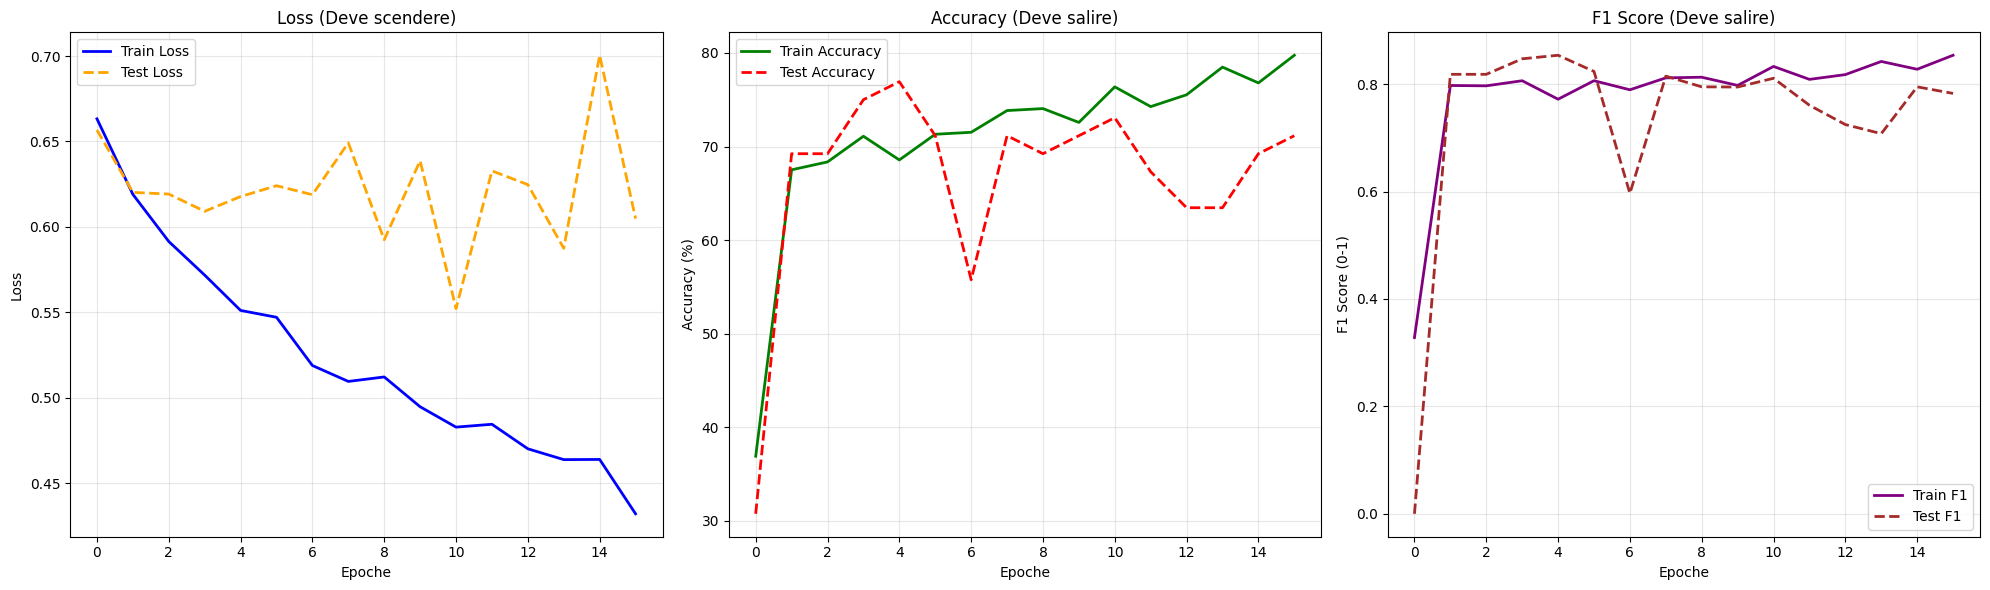

In [ ]:
import matplotlib.pyplot as plt

# Creiamo una figura con 3 grafici affiancati (1 riga, 3 colonne)
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# --- Grafico 1: LOSS (Errore) ---
# Questo ci dice se il modello sta imparando (deve scendere)
axs[0].plot(train_loss_single_fold, label='Train Loss', color='blue', linewidth=2)
axs[0].plot(test_loss_single_fold, label='Test Loss', color='orange', linestyle='--', linewidth=2)
axs[0].set_title('Loss (Deve scendere)')
axs[0].set_xlabel('Epoche')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# --- Grafico 2: ACCURACY ---
# Ci dice la percentuale totale di risposte corrette (deve salire)
axs[1].plot(accuracy_list_single_fold_train, label='Train Accuracy', color='green', linewidth=2)
axs[1].plot(accuracy_list_single_fold, label='Test Accuracy', color='red', linestyle='--', linewidth=2)
axs[1].set_title('Accuracy (Deve salire)')
axs[1].set_xlabel('Epoche')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

# --- Grafico 3: F1 SCORE ---
# Critico per dati sbilanciati o medici: media armonica tra precisione e recupero
axs[2].plot(f1_list_single_fold_train, label='Train F1', color='purple', linewidth=2)
axs[2].plot(f1_list_single_fold, label='Test F1', color='brown', linestyle='--', linewidth=2)
axs[2].set_title('F1 Score (Deve salire)')
axs[2].set_xlabel('Epoche')
axs[2].set_ylabel('F1 Score (0-1)')
axs[2].legend()
axs[2].grid(True, alpha=0.3)

plt.tight_layout() # Aggiusta automaticamente gli spazi tra i grafici
plt.show()

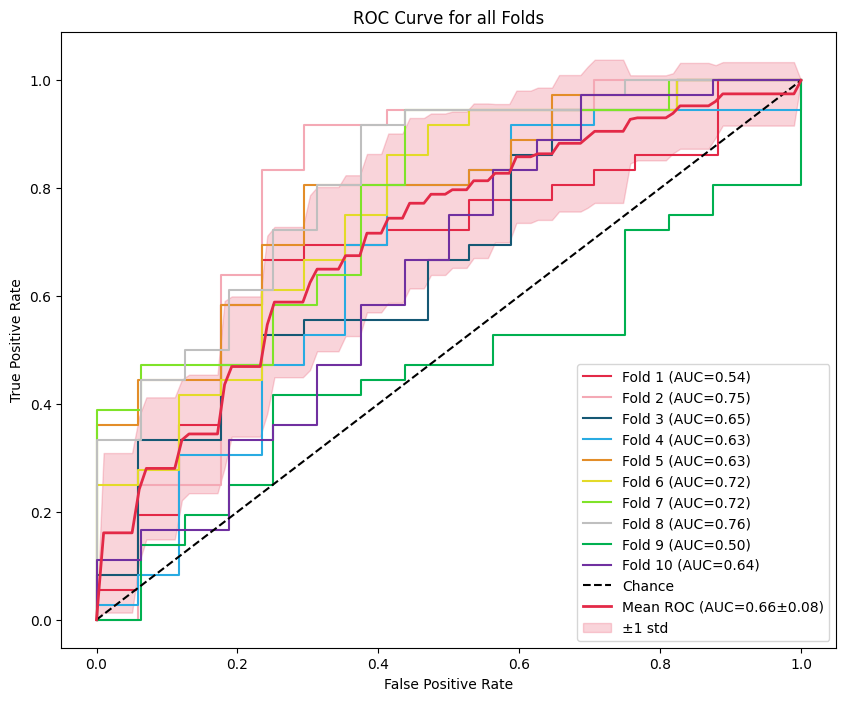

In [ ]:
plt.figure(figsize=(10, 8))

# Custom color palette
colors = [
    "#E32947",  # red
    "#F4A9B5",  # pink
    "#155874",  # dark blue
    "#29ABE2",  # light blue
    "#E38D29",  # orange
    "#E3DA29",  # yellow
    "#7FE329",  # green (flashy)
    "#BFBFBF",  # grey
    "#00B050",  # green (basic)
    "#7030A0",  # purple
    "#996633",  # brown
]
# Repeat colors if more folds than colors
while len(colors) < len(fpr_list_all_folds):
    colors += colors

mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

for i in range(len(fpr_list_all_folds)):
    interp_tpr = np.interp(mean_fpr, fpr_list_all_folds[i], tpr_list_all_folds[i])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    auc_val = auc_score_list_all_folds[i] if i < len(auc_score_list_all_folds) else None
    aucs.append(auc_val)
    plt.plot(
        fpr_list_all_folds[i],
        tpr_list_all_folds[i],
        color=colors[i],
        label=f'Fold {i+1} (AUC={auc_val:.2f})'
    )

plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Chance')

# Mean and std curves
tprs = np.array(tprs)
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
plt.plot(
    mean_fpr,
    mean_tpr,
    color="#E32947",
    label=f'Mean ROC (AUC={mean_auc:.2f}±{std_auc:.2f})',
    linewidth=2
)
plt.fill_between(
    mean_fpr,
    mean_tpr - std_tpr,
    mean_tpr + std_tpr,
    color="#E32947",
    alpha=0.2,
    label='±1 std'
)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for all Folds')
plt.legend(loc='lower right')
plt.show()

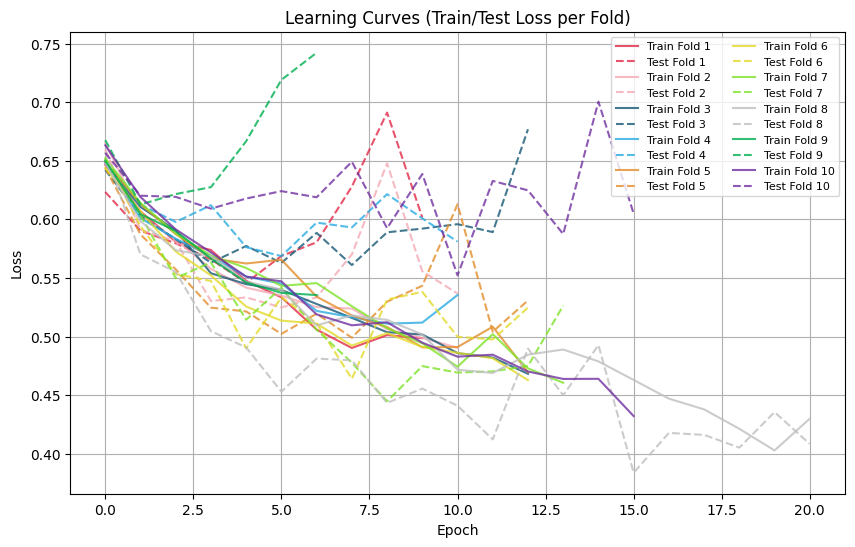

In [ ]:
# Plot learning curves (train and test loss per epoch for each fold)
plt.figure(figsize=(10, 6))

for i in range(len(train_loss_all_folds)):
    plt.plot(train_loss_all_folds[i], color=colors[i % len(colors)], alpha=0.8, label=f'Train Fold {i+1}')
    plt.plot(test_loss_all_folds[i], color=colors[i % len(colors)], alpha=0.8, linestyle='--', label=f'Test Fold {i+1}')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curves (Train/Test Loss per Fold)")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.show()

In [ ]:
print(f"Accuracy: {accuracy_list_all_folds}")
print(f"Accuracy Train: {accuracy_list_all_folds_train}")
print(f"F1 Score: {f1_list_all_folds}")
print(f"F1 Score Train: {f1_list_all_folds_train}")
print(f"Sensitivity: {sensitivity_list_all_folds}")
print(f"Sensitivity Train: {sensitivity_list_all_folds_train}")
print(f"Specificity: {specificity_list_all_folds}")
print(f"Specificity Train: {specificity_list_all_folds_train}")
print(f"AUC: {auc_score_list_all_folds}")
print(f"AUC Train: {auc_score_list_all_folds_train}")
print(f"Test Loss: {test_loss_max}")
print(f"Train Loss: {train_loss_max}")
print(f"Epochs: {epochs_all_fold}")

Accuracy: [69.81132075471697, 81.13207547169812, 75.47169811320755, 73.58490566037736, 73.58490566037736, 79.24528301886792, 80.76923076923077, 80.76923076923077, 69.23076923076923, 76.92307692307693]
Accuracy Train: [68.71035940803382, 69.3446088794926, 75.47568710359408, 69.55602536997885, 71.45877378435517, 72.93868921775899, 72.78481012658227, 81.43459915611815, 67.9324894514768, 68.56540084388185]
F1 Score: [0.813953488372093, 0.868421052631579, 0.8395061728395061, 0.825, 0.825, 0.8571428571428571, 0.8717948717948718, 0.8648648648648649, 0.8181818181818182, 0.8536585365853658]
F1 Score Train: [0.7777777777777778, 0.7883211678832117, 0.823170731707317, 0.7894736842105263, 0.7982062780269058, 0.8054711246200608, 0.8088888888888889, 0.8633540372670807, 0.7967914438502673, 0.7718223583460949]
Sensitivity: [np.float64(0.9722222222222222), np.float64(0.9166666666666666), np.float64(0.9444444444444444), np.float64(0.9166666666666666), np.float64(0.9166666666666666), np.float64(0.91666666

=== REPORT PERFORMANCE MEDIE (10-Fold CV) ===
      Accuracy  F1 Score  Sensitivity (Recall)  Specificity     AUC
mean    0.7605    0.8438                0.9389       0.3732  0.6560
std     0.0446    0.0221                0.0341       0.1999  0.0858
min     0.6923    0.8140                0.8889       0.0000  0.5000
max     0.8113    0.8718                1.0000       0.6250  0.7569


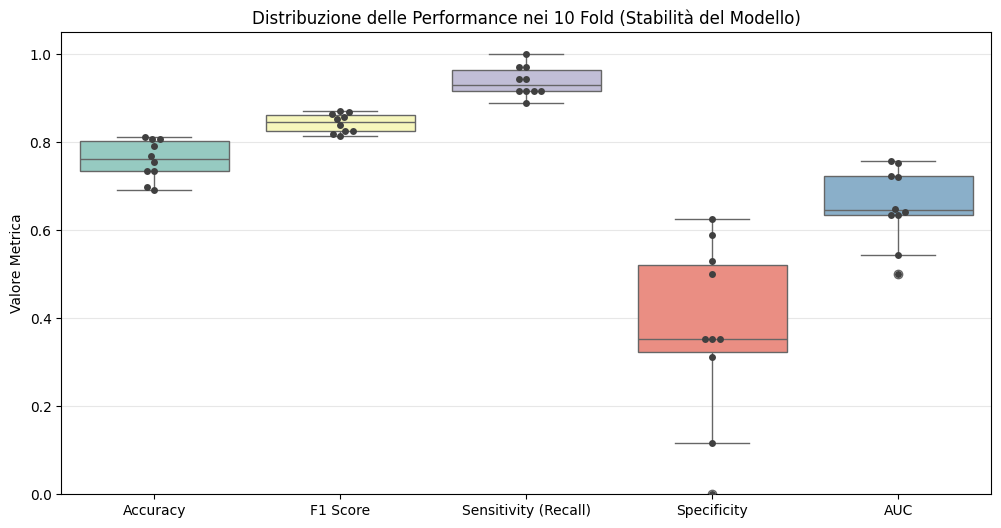

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Creazione di un DataFrame con tutti i risultati
results_data = {
    'Accuracy': np.array(accuracy_list_all_folds) / 100,  # <--- DIVISO PER 100
    'F1 Score': f1_list_all_folds,
    'Sensitivity (Recall)': sensitivity_list_all_folds,
    'Specificity': specificity_list_all_folds,
    'AUC': auc_score_list_all_folds
}

df_results = pd.DataFrame(results_data)

# 2. Calcolo delle Statistiche (Media e Deviazione Standard)
# La deviazione standard (std) ti dice quanto il modello è "instabile" tra un fold e l'altro
summary = df_results.describe().loc[['mean', 'std', 'min', 'max']]

print("=== REPORT PERFORMANCE MEDIE (10-Fold CV) ===")
print(summary.round(4))

# 3. Visualizzazione Grafica (Boxplot)
# Questo grafico è fondamentale: la linea verde è la mediana, la scatola è dove cade il 50% dei casi.
# Se la scatola è molto "alta", il modello è instabile. Se è schiacciata, è molto robusto.
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_results, palette="Set3")
sns.swarmplot(data=df_results, color=".25") # Aggiunge i punti reali per vedere la dispersione

plt.title('Distribuzione delle Performance nei 10 Fold (Stabilità del Modello)')
plt.ylabel('Valore Metrica')
plt.grid(True, axis='y', alpha=0.3)
plt.ylim(0, 1.05) # Fissa l'asse Y tra 0 e 1 (o poco più per l'accuracy se è in %)
# Se l'accuracy è in scala 0-100, commenta la riga sopra o adattala a (0, 105)

plt.show();